## Implement an analysis about football soccer using data analysys visualization and SQL tools



In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size
thick_size=16
label_size=20


###EXPLANATION ABOUT BETTING COLUMNS AT      https://www.football-data.co.uk/notes.txt
##FROM https://www.football-data.co.uk/italym.php 
## Fetching data
#Connecting to database
path = "./"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)


In [23]:
from matplotlib import rc
rc("text", usetex=False)

In [24]:
#####Fetch all tables in sqlite database

sql_query = """SELECT * FROM sqlite_master  WHERE type='table';"""
all_tables=pd.read_sql(sql_query, conn)
all_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [25]:
###Store some tables in separate pandas
country_data = pd.read_sql("SELECT * FROM Country;", conn)
league_data = pd.read_sql("SELECT * FROM League;", conn)
league_data["country_name"]=country_data["name"]
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team ORDER BY team_long_name;", conn)
team_stats_data=pd.read_sql("SELECT * FROM Team_Attributes;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

In [26]:
###Merge player_name and player_stats tables by calling how="outer"

players_all_data=pd.merge(player_stats_data,player_data,how="outer",on=["player_api_id"])
players_all_data["Date"]=pd.to_datetime(players_all_data.date)
players_all_data["year"]=players_all_data["Date"].apply(lambda x: x.year)



In [27]:
players_all_data.head()

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_positioning,gk_reflexes,id_y,player_name,player_fifa_api_id_y,birthday,height,weight,Date,year
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,8.0,8.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18,2016
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,8.0,8.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19,2015
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,8.0,8.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21,2015
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,7.0,7.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20,2015
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,7.0,7.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22,2007


## Arrange Data into Features Matrix

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

In [29]:
df=players_all_data.sort_values("year")
year=2015
df=df[df.year==year]

all_features = ["player_name",'overall_rating', 'potential','crossing', 'finishing', 'heading_accuracy',
            'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
            'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
            'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
            'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
            'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
            'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
            'gk_reflexes','height', 'weight']

features = ['crossing', 'finishing', 'heading_accuracy',
            'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
            'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
            'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
            'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
            'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
            'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
            'gk_reflexes','height', 'weight']





## KMeans Clustering


In [30]:
# Apply Standardization to features matrix X
x = df.loc[:, features].dropna().values
x = StandardScaler().fit_transform(x)

# Make an instance of KMeans with 3 clusters
kmeans = KMeans(n_clusters=2, random_state=1)

# Fit only on a features matrix
kmeans.fit(x)

KMeans(n_clusters=2, random_state=1)

In [31]:
# Get labels and cluster centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
x = pd.DataFrame(x, columns = features)


In [32]:
kmeans.inertia_

723795.9473043052

## Visually Evaluate the Clusters


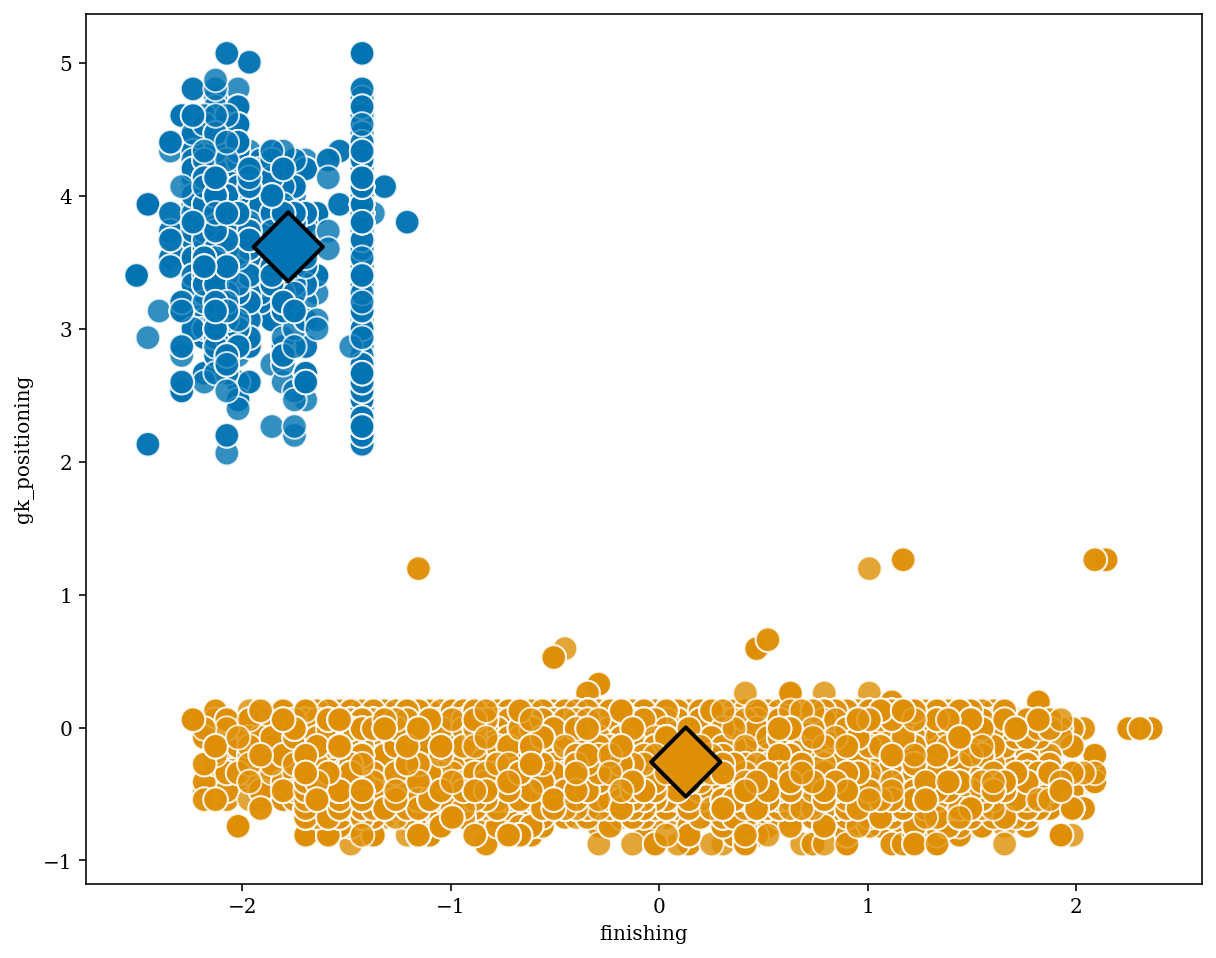

In [147]:


cluster_centers = pd.DataFrame(centroids, columns = features)


# Set the figure size
plt.figure(figsize=(10, 8))
xdat='finishing'
ydat='gk_positioning'

#Plot the Clusters
ax = sns.scatterplot(data = x,
                     x = xdat,
                     y = ydat, 
                     hue =labels, 
                     palette = 'colorblind', 
                     alpha = 0.8, 
                     s = 150,
                     legend = False)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x = xdat,
                     y = ydat, 
                     hue = cluster_centers.index, 
                     palette = 'colorblind', 
                     s = 600,
                     marker = 'D',
                     ec = 'black', 
                     legend = False
                    )

## What are the most important features in the classification?

In [153]:
x.columns

Index(['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'height',
       'weight'],
      dtype='object')

In [150]:
x[["gk_diving","gk_reflexes"]].describe()

,crossing,gk_reflexes
count,3.181800e+04,3.181800e+04
mean,-1.322023e-16,-4.376968e-17
std,1.000016e+00,1.000016e+00
min,-2.964647e+00,-8.299418e-01
25%,-5.673684e-01,-3.948142e-01
50%,2.716792e-01,-2.704920e-01
75%,6.912030e-01,-8.400871e-02
max,2.189502e+00,4.702396e+00


(-3.0, 3.0)

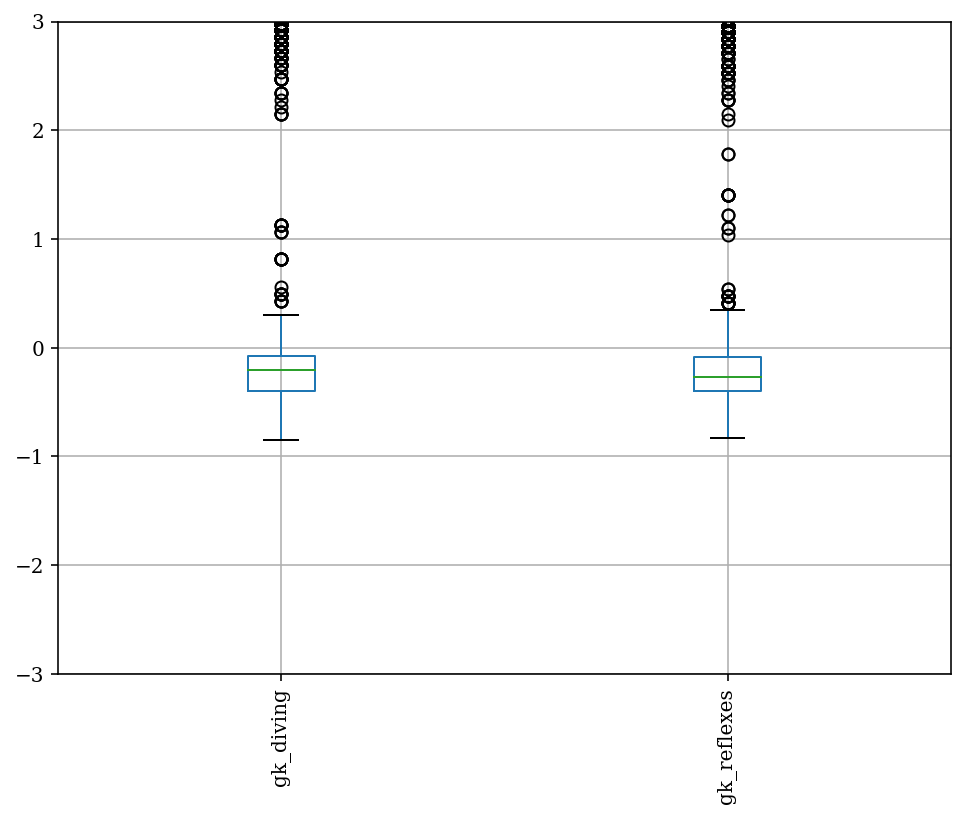

In [160]:
x[["gk_diving","gk_reflexes"]].boxplot(rot=90)
plt.ylim(-3,3)

From the plot above we can see that the goalies represent outliers in the data set. This poses the simple question: can we identify all goalies by selecting all the outliers?


In [159]:
import eli5
eli5.explain_weights(kmeans, feature_names=list(x.columns))

Explanation(estimator='KMeans(n_clusters=2, random_state=1)', description=None, error='estimator KMeans(n_clusters=2, random_state=1) is not supported', method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

## Choose the right number of Clusters¶

In [16]:
df=players_all_data.sort_values("year")
df=df[df.year==year]
df=df[all_features].dropna()
df["position"]=list(labels)
df=df.sort_values("overall_rating",ascending=False)
df["position"]=df["position"].apply(lambda x: "GK" if x==0 else "Field" ).to_list()
df_field=df[df.position=="Field"]

features = ['crossing', 'finishing', 'heading_accuracy',
            'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
            'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
            'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
            'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
            'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle','height', 'weight']




df_field=df_field[features]


### The Within Cluster Sum of Squares (WCSS)


Also known as the elbow method, it recommends as the optimal number of clusters that at which the WCSS has an inflection point or does not decrease significantly anymore (the elbow)

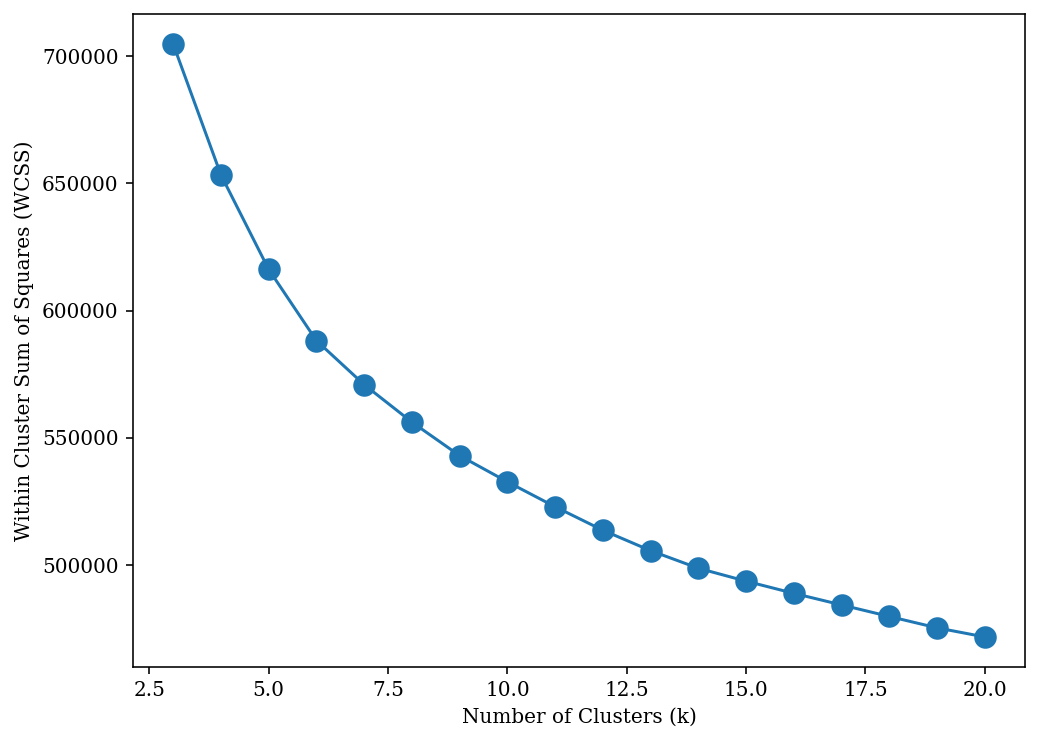

In [17]:
# Apply Standardization to features matrix X
x = df_field.loc[:, features].dropna().values

x = StandardScaler().fit_transform(x)



wcss = []
for k in range(3, 21):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(x)
    wcss.append(km.inertia_)

wcss_series = pd.Series(wcss, index = range(3, 21))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

### The Average Silhouette Score

In this case the optimal value of k corresponds to the maximum value of the Average Silhouette score

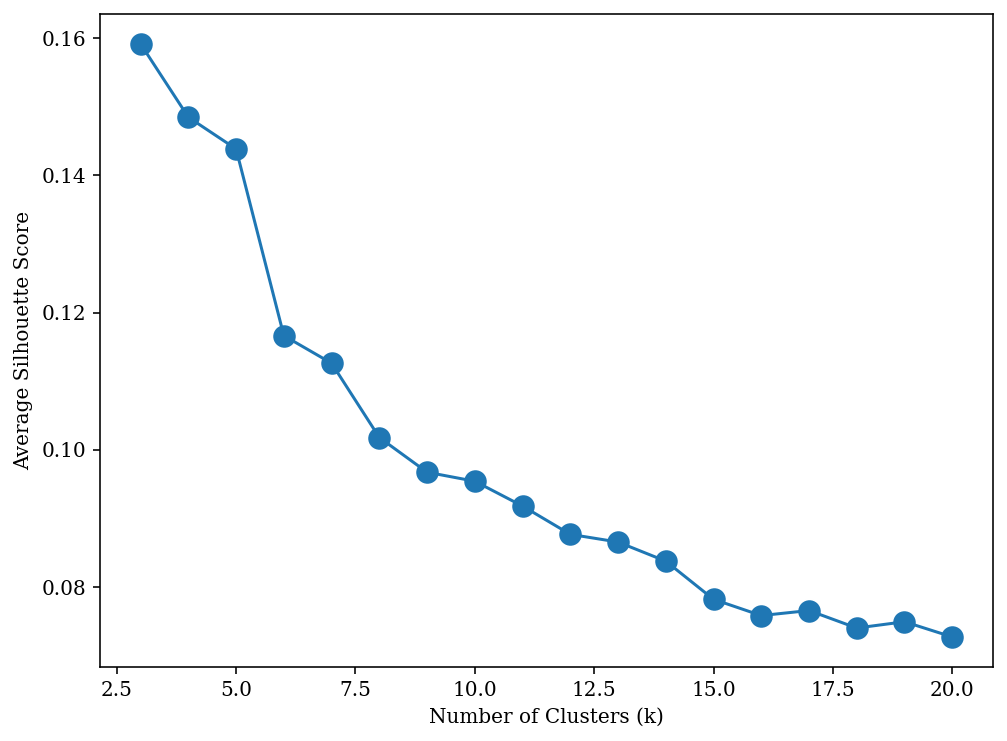

In [18]:
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(3, 21):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(x)
    silhouette.append(silhouette_score(x, km.labels_))

silhouette_series = pd.Series(silhouette, index = range(3, 21))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Average Silhouette Score')

### The Calinski Harabasz Score

the optimal value of k correspond to that of either the maximum value or the first abrupt change

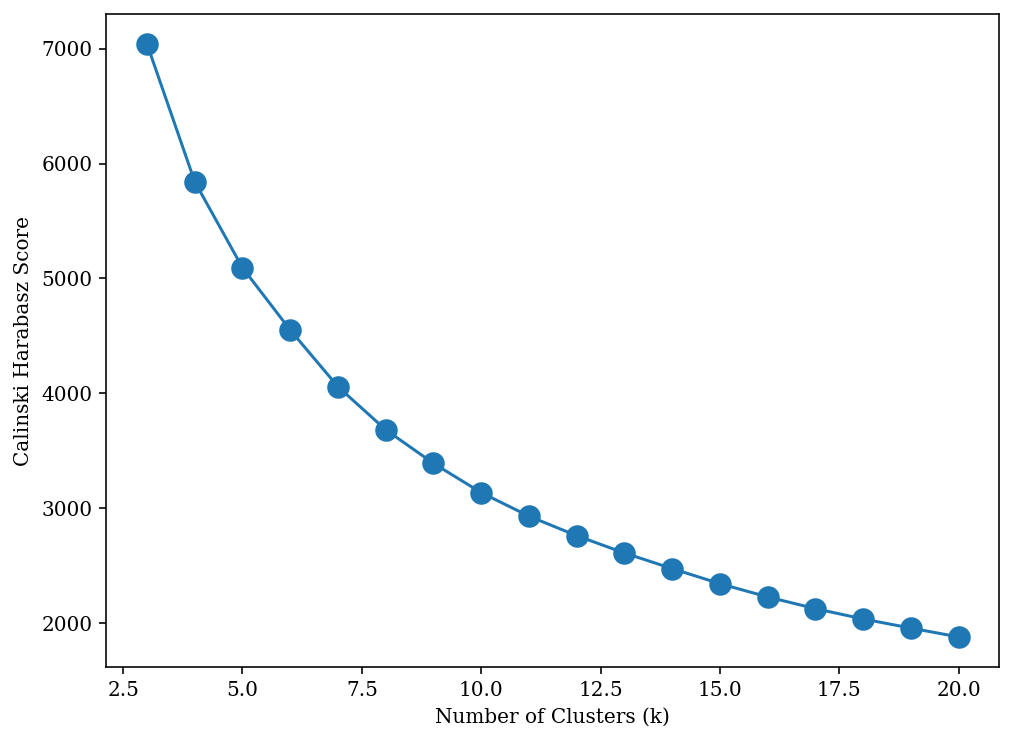

In [19]:
from sklearn.metrics import calinski_harabasz_score

calinski = []
for k in range(3, 21):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(x)
    calinski.append(calinski_harabasz_score(x, km.labels_))

calinski_series = pd.Series(calinski, index = range(3, 21))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = calinski_series, x = calinski_series.index)
ax = sns.scatterplot(y = calinski_series, x = calinski_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Calinski Harabasz Score')